In [ ]:
#!conda install -c conda-forge lightgbm
#!pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb
#import optuna.integration.lightgbm as opt_lgb

In [ ]:
#上限表示数を拡張
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 200)

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [ ]:
df_1_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_SwinTransformerLarge384_V2Large256.csv")
df_1_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_SwinTransformerLarge384_V2Large256.csv")

In [ ]:
df_2_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efb2_rinnabase.csv")
df_2_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efb2_rinnabase.csv")

In [ ]:
df_2_tr = df_2_tr.drop(df_2_tr.columns[0:352], axis=1)

In [ ]:
df_2_ts = df_2_ts.drop(df_2_ts.columns[0:352], axis=1)

In [ ]:
df_3_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_swinv2base256_ginza510electra.csv")
df_3_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_swinv2base256_ginza510electra.csv")

In [ ]:
df_4_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efv2b2_resnet152_jaginza.csv")
df_4_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efv2b2_resnet152_jaginza.csv")

In [ ]:
df_4_tr = df_4_tr.drop(df_4_tr.columns[0:865], axis=1)

In [ ]:
df_4_ts = df_4_ts.drop(df_4_ts.columns[0:865], axis=1)

In [ ]:
#swinL384,swinV2L256,Roberta-text,efb2
df_tmp_tr_1 = pd.concat([df_1_tr,df_2_tr],axis=1)
df_tmp_ts_1 = pd.concat([df_1_ts,df_2_ts],axis=1)

In [ ]:
#ginza510-electra-base-text,swinv2base256
df_tmp_tr_2 = pd.concat([df_tmp_tr_1,df_3_tr],axis=1)
#df_tmp_tr_2 = pd.concat([df_1_tr,df_3_tr],axis=1)
df_tmp_ts_2 = pd.concat([df_tmp_ts_1,df_3_ts],axis=1)
#df_tmp_ts_2 = pd.concat([df_1_ts,df_3_ts],axis=1)

In [ ]:
#efficientnetv2b2,resnet152,jaginza(ginza_electra_text)
df_tmp_tr_3 = pd.concat([df_tmp_tr_2,df_4_tr],axis=1)
df_tmp_ts_3 = pd.concat([df_tmp_ts_2,df_4_ts],axis=1)

In [ ]:
train_tmp = df_tmp_tr_3.drop(["is_laugh","odai_photo_file_name"], axis=1)

In [ ]:
test_tmp = df_tmp_ts_3.drop(["odai_photo_file_name"], axis=1)

In [ ]:
#tr_van = pd.read_csv('/content/drive/MyDrive/nishika/embeded/embedding_train_image_VanLarge.csv')

In [ ]:
#ts_van = pd.read_csv('/content/drive/MyDrive/nishika/embeded/embedding_test_image_VanLarge.csv')

In [ ]:
#tr_van = tr_van.drop(["text_len","Unnamed: 0","odai_photo_file_name","is_laugh","id","text"], axis=1)

In [ ]:
#ts_van = ts_van.drop(["text_len","Unnamed: 0","odai_photo_file_name","id","text"], axis=1)

In [ ]:
#tr_tmp_df = pd.concat([train_tmp,tr_van],axis=1)
#ts_tmp_df = pd.concat([test_tmp,ts_van],axis=1)

In [ ]:
tr_long = pd.read_csv('/content/drive/MyDrive/nishika/embeded/embedding_train_text_long_roberata.csv')

In [ ]:
ts_long = pd.read_csv('/content/drive/MyDrive/nishika/embeded/embedding_test_text_long_roberta.csv')

In [ ]:
print(tr_long)

In [ ]:
tr_long = tr_long.drop(["text_len","Unnamed: 0","odai_photo_file_name","is_laugh","id","text"], axis=1)

In [ ]:
ts_long = ts_long.drop(["text_len","Unnamed: 0","odai_photo_file_name","id","text"], axis=1)

In [ ]:
tr_tmp2_df = pd.concat([train_tmp,tr_long],axis=1)
ts_tmp2_df = pd.concat([test_tmp,ts_long],axis=1)

In [ ]:
train = pd.concat([tr_tmp2_df,train_df],axis=1)
test = pd.concat([ts_tmp2_df,test_df],axis=1)

In [ ]:
train["text_len"] = train["text"].str.len()
test["text_len"] = test["text"].str.len()

In [ ]:
y = train["is_laugh"]
X = train.drop(["odai_photo_file_name","is_laugh","id","text"], axis=1)

X_test = test.drop(["odai_photo_file_name","id","text"], axis=1)

In [ ]:

X = X.T.drop_duplicates().T
X_test = X_test.T.drop_duplicates().T 


In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.001,
    'lambda_l1': 8.553323365580143, 
    'lambda_l2': 0.00024389221237366783, 
    'num_leaves': 240, 
    'feature_fraction': 0.6839999999999999, 
    'bagging_fraction': 0.6378550454605715, 
    'bagging_freq': 1,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":9,
    'min_child_samples': 20
    }

In [ ]:
# 予測値を格納するdf
# df to store the predicted value
preds_lgb = pd.DataFrame()

for k, (tr_id, vl_id) in enumerate(kf.split(X, y)):
    print("="*50)
    print(f"               KFold{k+1}")
    print("="*50)
    
    X_train, X_val = X.iloc[tr_id, :], X.iloc[vl_id, :]
    y_train, y_val = y.iloc[tr_id], y.iloc[vl_id]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    
    model_lgb = lgb.train(params=params,
                          train_set=lgb_train,
                          valid_sets=lgb_val,
                          num_boost_round=100000,
                          early_stopping_rounds=200,
                          verbose_eval=1000)
    
    pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
    pred_lgb = pd.DataFrame(pred_lgb)
    
    # 予測値を横に連結していく
    # Concatenate the predictions horizontally
    preds_lgb = pd.concat([preds_lgb, pred_lgb], axis=1)

In [ ]:
preds_lgb

In [ ]:
label = preds_lgb.mean(axis=1)
label

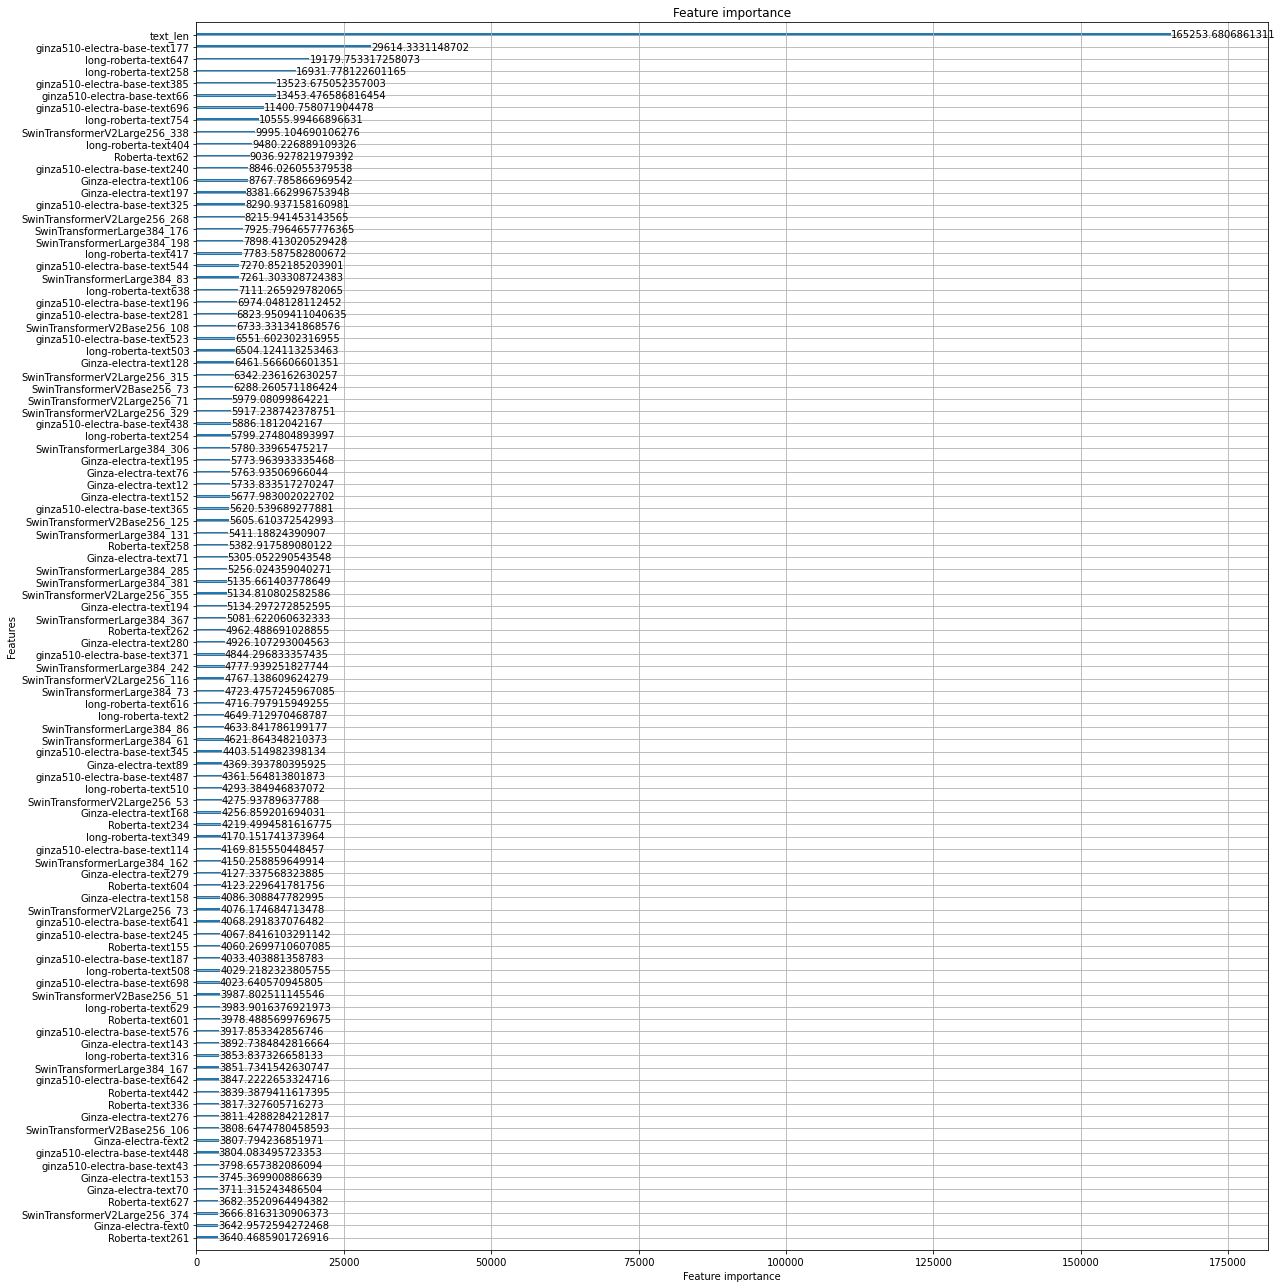

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(model_lgb, figsize=(18,18), max_num_features=100, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
submission_df["is_laugh"] = label

submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.424958
1,tsgqmfpef,0.403522
2,owjcthkz2,0.327007
3,rvgaocjyy,0.407383
4,uxtwu5i69,0.826344


In [ ]:
submission_df.to_csv(('/content/drive/MyDrive/nishika/sub.csv'), index=False)